# Combine Catalogs
There's a LOT of EB catalogs in the literature, and some very good ones not yet published as well... In total we'll easily have a sample of many thousands of EBs to consider if we combine them

Here we'll combine catalogs to make a super-sample, and produce an easier to use file for the rest of the project.

Read in:
- ASAS-SN EBs
- Catalina EBs
- Kepler EBs (Villanova)
- CEV
- Erin Howard's TESS Sample (X-match to Gaia)

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from astropy.table import Table
from scipy.optimize import curve_fit
from matplotlib.colors import LogNorm

from glob import glob

In [2]:
import matplotlib
matplotlib.rcParams.update({'font.size':18})
# matplotlib.rcParams.update({'font.family':'serif'})

# for the TESS Science Online 48hr sprint, we'll be using Cyberpunk for the graphics!
# https://github.com/dhaitz/mplcyberpunk
import mplcyberpunk
plt.style.use("cyberpunk")

## Read in every catalog

some need cleaning up, apply (roughly) uniform quality cuts where possible

In [3]:
# KEPLER

# already x-matched the Villanova EBs to Gaia DR2 & the Bailer-Jones catalogs
file = '../data/1543957677477A.csv'
df = pd.read_csv(file)

# df.columns
ok = np.where(np.isfinite(df['parallax']) & # this is basically the same as the TGAS file...
              (df['parallax_error'] < 0.1) &
              (df['ModFlag'] == 1) & 
              (df['ResFlag'] == 1) &
              np.isfinite(df['bp_rp']) & 
              (df['phot_bp_mean_flux_error']/df['phot_bp_mean_flux'] < 0.02) & 
              (df['phot_rp_mean_flux_error']/df['phot_rp_mean_flux'] < 0.02) & 
              (df['phot_g_mean_flux_error']/df['phot_g_mean_flux'] < 0.02) & 
              (df['angDist'] < 0.5) & (df['angDist.1'] < 0.5))[0]

print(df.shape, ok.shape)

(7160, 75) (2346,)


In [4]:
# CATALINA

# i can't recall which catalog this came from originally, but it has been xmatched to Gaia DR2 & BailerJones
file = '../data/1540942562357A.csv'
df2 = pd.read_csv(file)

# df2.columns
ok2 = np.where(np.isfinite(df2['parallax']) & # this is basically the same as the TGAS file...
               (df2['parallax_error']/df2['parallax'] < 0.1) &
               (df2['ModFlag'] == 1) & 
               (df2['ResFlag'] == 1) &
               np.isfinite(df2['bp_rp']) & 
               (df2['phot_bp_mean_flux_error']/df2['phot_bp_mean_flux'] < 0.02) & 
               (df2['phot_rp_mean_flux_error']/df2['phot_rp_mean_flux'] < 0.02) & 
               (df2['phot_g_mean_flux_error']/df2['phot_g_mean_flux'] < 0.02) & 
               (df2['angDist'] < 0.5) &
               np.isfinite(df2['Per']))[0]

print(df2.shape, ok2.shape)

(59096, 57) (8863,)


In [5]:
# #ASAS-SN
# asas = pd.read_csv('../data/asassn-catalog.csv')
# asas.columns

# okA = np.where((asas['Mean VMag'] < 16) & 
#                (asas['Jmag'] - asas['Kmag'] > -0.5) &
#                (asas['Jmag'] - asas['Kmag'] < 2) &
#                (asas['Classification Probability'] > 0.9) & 
#                (asas['Type'] == 'EA') | (asas['Type'] == 'EB') | (asas['Type'] == 'EW'))[0]

# AokA = np.where((asas['Parallax Error'][okA]/asas['Parallax'][okA] < 0.1) &
#                 np.isfinite(asas['Jmag'][okA]) & 
#                 np.isfinite(asas['Kmag'][okA]) & 
#                 (asas['Jmag'][okA] - asas['Kmag'][okA] > -0.5) &
#                 (asas['Jmag'][okA] - asas['Kmag'][okA] < 2) &
#                 (asas['Parallax'][okA] > 0) &
#                 np.isfinite(asas['Parallax'][okA]))[0]
# print(asas.shape, okA.shape, AokA.shape)

In [6]:
#ASAS-SN
asassn = pd.read_csv('../data/2020-09-08-17_38_28.csv')
asassn.columns


Index(['ID', 'ASASSN_Name', 'Other Names', 'RAJ2000', 'DEJ2000', 'I', 'b',
       'Mean Vmag', 'Amplitude', 'Period', 'Type', 'Class_Probability',
       'LKSL Statistic', 'RFR_score', 'EpochHJD', 'GDR2_ID', 'Gmag', 'e_Gmag',
       'BPmag', 'e_BPmag', 'RPmag', 'e_RPmag', 'BP-RP', 'parallax',
       'parallax_error', 'parallax_over_error', 'PMRA', 'e_PMRA', 'PMDEC',
       'e_PMDEC', 'V_t', 'dist', 'ALLWISE_ID', 'Jmag', 'e_Jmag', 'Hmag',
       'e_Hmag', 'Kmag', 'e_Kmag', 'W1mag', 'e_W1mag', 'W2mag', 'e_W2mag',
       'W3mag', 'e_W3mag', 'W4mag', 'e_W4mag', 'J-K', 'W1-W2', 'W3-W4',
       'APASS_DR9ID', 'APASS_Vmag', 'e_APASS_Vmag', 'APASS_Bmag',
       'e_APASS_Bmag', 'APASS_gpmag', 'e_APASS_gpmag', 'APASS_rpmag',
       'e_APASS_rpmag', 'APASS_ipmag', 'e_APASS_ipmag', 'B-V', 'E(B-V)',
       'Reference', 'Periodic', 'ASASSN_Discovery', 'URL'],
      dtype='object')

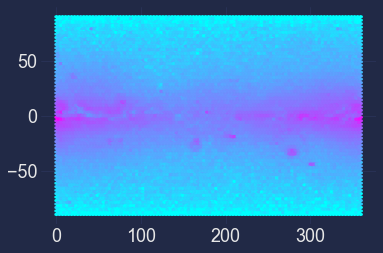

In [7]:
plt.hexbin(asassn['I'], asassn['b'], norm=LogNorm())

In [8]:
# drop W Uma's for now?
EBs = np.where(((asassn['Type'] == 'EA') | (asassn['Type'] == 'EB')) & # (asassn['Type'] == 'EW') | 
               (asassn['Class_Probability'] > 0.99) & 
               (asassn['parallax_over_error'] > 10) & 
               (asassn['parallax'] > 0) & 
               np.isfinite(asassn['parallax']) &
               (asassn['e_Gmag'] < 0.01)
              )[0]

print(asassn.shape, EBs.shape)

(666502, 67) (36103,)


In [9]:
# note: (I,b) is acutally Galactic coordinates (l,b), a typo in ASAS-SN
asassn[['ID', 'I','b', 'Amplitude', 'Period', 'Gmag', 'BPmag', 
        'RPmag', 'dist', 'Jmag', 'Kmag', 'W1mag']].loc[EBs].to_csv('asassn_ebs_36k.csv')

In [10]:
# Catalog of Eclipsing Variables
# http://vizier.u-strasbg.fr/viz-bin/VizieR?-source=J/A+A/446/785
# xmatched to Gaia DR2

cev = pd.read_csv('../data/CEV-Gaia-2arcsec.csv')
# cev.columns

okC = np.where(np.isfinite(cev['parallax']) & 
               (cev['parallax_error']/cev['parallax'] < 0.1) &
               np.isfinite(cev['bp_rp']) & 
               (cev['phot_bp_mean_flux_error']/cev['phot_bp_mean_flux'] < 0.02) & 
               (cev['phot_rp_mean_flux_error']/cev['phot_rp_mean_flux'] < 0.02) & 
               (cev['phot_g_mean_flux_error']/cev['phot_g_mean_flux'] < 0.02) & 
               np.isfinite(cev['Per']))[0]

print(cev.shape, okC.shape)

(4334, 53) (1252,)


In [11]:
# add Erin's catalog, use TIC to join with Trevor's Gaia-xmatch
elh = pd.read_csv('../data/ehoward.txt')

# KIC-to-TIC conversion, if needed?
KICTIC = pd.read_csv('/Users/james/Dropbox/research_projects/kic2tic/KIC2TIC.csv')

# the TESS-Gaia xmatch from Trevor
gdir = '/Users/james/Dropbox/research_projects/TESS-Gaia/'
gfiles = glob(gdir+'*1arsec-result.csv')
gaia0 = pd.concat((pd.read_csv(f) for f in gfiles), ignore_index=True, sort=False)

EHow = pd.merge(elh, gaia0, left_on='TIC', right_on='ticid', how='inner').drop_duplicates(subset=['TIC'])

Eok = np.where(np.isfinite(EHow['parallax']) & 
               (EHow['parallax_error']/EHow['parallax'] < 0.1) &
               np.isfinite(EHow['bp_rp']) & 
               (EHow['phot_bp_mean_flux_error']/EHow['phot_bp_mean_flux'] < 0.02) & 
               (EHow['phot_rp_mean_flux_error']/EHow['phot_rp_mean_flux'] < 0.02) & 
               (EHow['phot_g_mean_flux_error']/EHow['phot_g_mean_flux'] < 0.02)
              )[0]

print(EHow.shape, Eok.shape)

(464, 139) (418,)


In [12]:
gaia = gaia0.drop_duplicates(subset=['source_id'])

gok = np.where(np.isfinite(gaia['parallax']) & 
               (gaia['parallax_error']/gaia['parallax'] < 0.1) &
               np.isfinite(gaia['bp_rp']) & 
               (gaia['phot_bp_mean_flux_error']/gaia['phot_bp_mean_flux'] < 0.02) & 
               (gaia['phot_rp_mean_flux_error']/gaia['phot_rp_mean_flux'] < 0.02) & 
               (gaia['phot_g_mean_flux_error']/gaia['phot_g_mean_flux'] < 0.02)
              )[0]
print(gaia.shape, gok.size)

(228153, 138) 217375


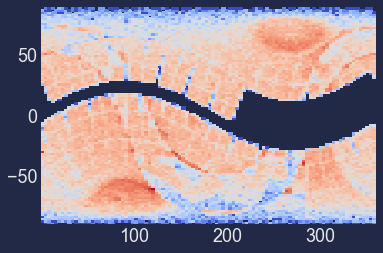

In [13]:
_ = plt.hist2d(gaia['ra'].values[gok], gaia['dec'].values[gok], bins=100, cmap=plt.cm.coolwarm, norm=LogNorm())

In [14]:
#  Malkov 2020, http://vizier.u-strasbg.fr/viz-bin/VizieR?-source=J%2FMNRAS%2F491%2F5489%2Ftablea1
m20 = pd.read_csv('../data/1599574064401A.csv')

okM = np.where(np.isfinite(m20['parallax']) & 
               (m20['parallax_error']/cev['parallax'] < 0.1) &
               np.isfinite(m20['bp_rp']) & 
               (m20['phot_bp_mean_flux_error']/m20['phot_bp_mean_flux'] < 0.02) & 
               (m20['phot_rp_mean_flux_error']/m20['phot_rp_mean_flux'] < 0.02) & 
               (m20['phot_g_mean_flux_error']/m20['phot_g_mean_flux'] < 0.02) & 
               np.isfinite(m20['Per']))[0]

print(m20.shape, okM.shape)

(123, 63) (59,)


In [15]:
# any other catalogs?

## Combine

Make a single big Pandas dataframe

In [16]:
# columns to grab:
# make the CMD: distance, bp_rp color, Gmag
# def want to save Periods - they available for all catalogs?
# prob want to save Gaia "source_id" so we can unique the list

In [17]:
save_cols = ['source_id', 'ra', 'dec', 'bp_rp', 'parallax', 'phot_g_mean_mag', 'Per']

# Kepler 
# df[save_cols].loc[ok]

# Catalina
# df2[save_cols].loc[ok2]

# Catalog of Eclipsing Variables
# cev[save_cols].loc[okC]

# Malkov'20
# m20[save_cols].loc[okM]

# ASAS-SN
asassn.rename(columns={'GDR2_ID':'source_id', 'BP-RP':'bp_rp','Gmag':'phot_g_mean_mag', 
                       'Period':'Per', 'RAJ2000':'ra', 'DEJ2000':'dec'}, 
              inplace=True)
# asassn[save_cols].loc[EBs]

BigCat = pd.concat((df[save_cols].loc[ok], 
                    df2[save_cols].loc[ok2], 
                    cev[save_cols].loc[okC], 
                    m20[save_cols].loc[okM], 
                    asassn[save_cols].loc[EBs]), 
                   ignore_index=True, sort=False)

In [18]:
df.columns

Index(['angDist', 'angDist.1', 'id', 'RA_ICRS', 'DE_ICRS', 'rest', 'b_rest',
       'B_rest', 'rlen', 'ResFlag', 'ModFlag', 'angDist.2', 'ra_epoch2000',
       'dec_epoch2000', 'errHalfMaj', 'errHalfMin', 'errPosAng', 'source_id',
       'ra', 'ra_error', 'dec', 'dec_error', 'parallax', 'parallax_error',
       'pmra', 'pmra_error', 'pmdec', 'pmdec_error', 'duplicated_source',
       'phot_g_mean_flux', 'phot_g_mean_flux_error', 'phot_g_mean_mag',
       'phot_bp_mean_flux', 'phot_bp_mean_flux_error', 'phot_bp_mean_mag',
       'phot_rp_mean_flux', 'phot_rp_mean_flux_error', 'phot_rp_mean_mag',
       'bp_rp', 'radial_velocity', 'radial_velocity_error', 'rv_nb_transits',
       'teff_val', 'a_g_val', 'e_bp_min_rp_val', 'radius_val', 'lum_val',
       '_RAJ2000', '_DEJ2000', 'KIC', 'Per', 'BJD0', 'Morph', 'SC', 'LC', 'T3',
       'Simbad', '_RA', '_DE', '2MASS', 'RAJ2000', 'DEJ2000', 'errHalfMaj.1',
       'errHalfMin.1', 'errPosAng.1', 'Jmag', 'Hmag', 'Kmag', 'e_Jmag',
       'e_Hmag',

In [19]:
print(BigCat.shape, BigCat['source_id'].unique().size)

(48623, 7) 46004


In [20]:
BigCat.to_csv('BigCat.csv')


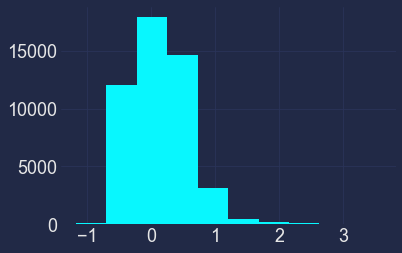

In [21]:
_ = plt.hist( np.log10(BigCat['Per'].astype('float')) )

In [22]:
longP = (BigCat['Per'].astype('float') > 10)
sum(longP)

1386

/Users/james/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0, 0.5, '$M_G$ (mag)')

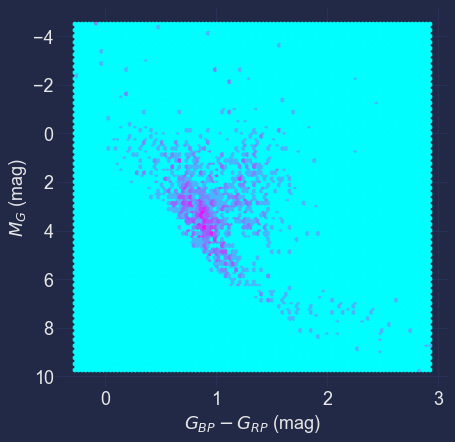

In [23]:
plt.figure(figsize=(7,7))
plt.hexbin(BigCat['bp_rp'][longP], 
            BigCat['phot_g_mean_mag'][longP] - 5. * np.log10(1000./BigCat['parallax'][longP]) + 5,
           norm=LogNorm(), cmap=plt.cm.cool)

plt.gca().invert_yaxis()

plt.xlabel('$G_{BP} - G_{RP}$ (mag)')
plt.ylabel('$M_G$ (mag)')

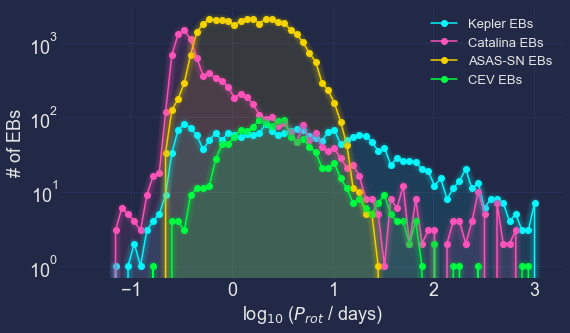

In [24]:
plt.figure(figsize=(9,5))
Hbins = np.linspace(-1.5, 3.1, num=75)

hist,be = np.histogram(np.log10(df['Per'][ok]), bins=Hbins)
plt.plot((be[1:]+be[:-1])/2, hist, '-o', label='Kepler EBs')

hist,be = np.histogram(np.log10(df2['Per'][ok2]), bins=Hbins)
plt.plot((be[1:]+be[:-1])/2, hist, '-o', label='Catalina EBs')

hist,be = np.histogram(np.log10(asassn['Per'][EBs].astype('float')), bins=Hbins)
plt.plot((be[1:]+be[:-1])/2, hist, '-o', label='ASAS-SN EBs')

hist,be = np.histogram(np.log10(cev['Per'][okC]), bins=Hbins)
plt.plot((be[1:]+be[:-1])/2, hist, '-o', label='CEV EBs')

plt.xlabel('log$_{10}$ ($P_{rot}$ / days)')
plt.yscale('log')
plt.ylabel('# of EBs')
plt.legend(fontsize=13)

# alas, these don't work w/ histograms... yet!
mplcyberpunk.add_glow_effects()

# plt.savefig('.png', dpi=300, bbox_inches='tight', pad_inches=0.25)

In [25]:
# save the TESS-Gaia xmatch, cleaned up and only saving same columns as the "BigCat"

gaia[save_cols[0:-1]].iloc[gok].to_csv('gaia_tess2min.csv')

are these interesting?

Brian Powell's first-pass look at the 48k EB's found these to be "interesting".

- which catalog are they from?
- what else can we say about them?

In [26]:
# interesting Brian Powell
intBP = [19,  262,  297,  736,  742,  767,  2371,  2413,  2490,  2643,  2913,  3026,  3066,  
         3101,  3167,  3191,  3205,  3208,  3225,  3537,  3573,  3688,  3844,  3898,  3957, 
         4107,  4136,  4216,  4286,  4363,  4467,  4760,  4878,  5217,  5248,  5346,  5375,  
         5447,  5448,  5477,  5535,  5547,  5587,  5623,  5671,  5684,  5864,  5897,  5904,  
         6152,  6177,  6204,  6262,  6266,  6311,  6361,  6376,  6406,  6424,  6553,  6559,  
         6599,  6628,  6706,  6707,  6746,  6748,  6756,  6829,  6850,  6856,  6861,  6871,  
         6895,  6965,  6966,  6984,  7058,  7075,  7108,  7121,  7131,  7134,  7137,  7143,  
         7152,  7156,  7262,  7269,  7271,  7307,  7342,  7369,  7378,  7407,  7412,  7413,  
         7431,  7473,  7497,  7500,  7603,  7612,  7630,  7633,  7654,  7667,  7678,  7722,  
         7776,  7832,  7967,  8060,  8103,  8114,  8147,  8172,  8192,  8284,  8423,  8432,  
         8448,  8451,  8454,  8505,  8531,  8546,  8573,  8611,  8690,  8738,  8746,  8794,  
         8814,  8853,  8899,  8955,  9014,  9019,  9051,  9062,  9073,  9161,  9219,  9243,  
         9400,  9535,  9543,  9698,  9715,  9724,  9739,  9778,  9805,  9812,  9869,  9876,  
         9886,  9978,  10035,  10044,  10117,  10322,  10449,  10666,  10784,  10863,  10876, 
         10916,  10938,  10988,  11006,  11149,  11203,  37788,  40000]

In [27]:
BigCat.iloc[intBP]['Per'].astype('float').values

array([0.2169003, 0.722065 , 0.799127 , 0.4681444, 0.4767224, 0.5131523,
       0.347532 , 0.272488 , 0.2919501, 0.465494 , 0.840048 , 0.382177 ,
       0.355664 , 0.694914 , 0.293042 , 0.636304 , 0.3199094, 0.323198 ,
       0.464729 , 0.752887 , 0.288941 , 0.475994 , 0.401703 , 0.339524 ,
       0.317536 , 0.710919 , 0.283201 , 0.350671 , 0.54242  , 0.458842 ,
       0.25162  , 0.276286 , 0.3502101, 0.749034 , 0.5531459, 0.333404 ,
       0.42085  , 0.352884 , 0.364769 , 0.0855217, 0.624049 , 0.6515434,
       0.38966  , 0.564438 , 0.3905095, 0.33132  , 0.87458  , 0.352286 ,
       0.443223 , 0.367363 , 0.3054771, 0.32615  , 0.652846 , 0.674894 ,
       0.358308 , 0.817193 , 0.4223597, 0.40843  , 0.918972 , 0.504949 ,
       0.303416 , 0.361859 , 0.6810198, 0.26271  , 0.2873314, 0.31629  ,
       0.2805196, 0.4069396, 0.3146376, 0.2820046, 0.800867 , 0.727168 ,
       0.8524567, 0.238035 , 0.3061639, 0.306161 , 0.3436232, 0.381934 ,
       0.660905 , 0.3538202, 0.2696326, 0.293024 , 